# Tensorflow Callbacks

Callbacks helps in preventing overfitting, to visualize training process, save checkpoints, debug the code etc..




Callbacks can be passed to keras methods such as fit, evaluate, and predict in order to hook into the various stages of the model training and inference lifecycle.

In [1]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfdt
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/Users/jacindhas/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the dataset for our experiment

In [2]:
data, info = tfdt.load('mnist', split = 'train[80%:]', with_info = True, as_supervised = True)

In [3]:
tfdt.as_dataframe(data.take(4),info)

2024-01-27 16:51:36.196047: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


,image,label
0,,8
1,,5
2,,3
3,,9


2024-01-27 16:51:36.379065: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


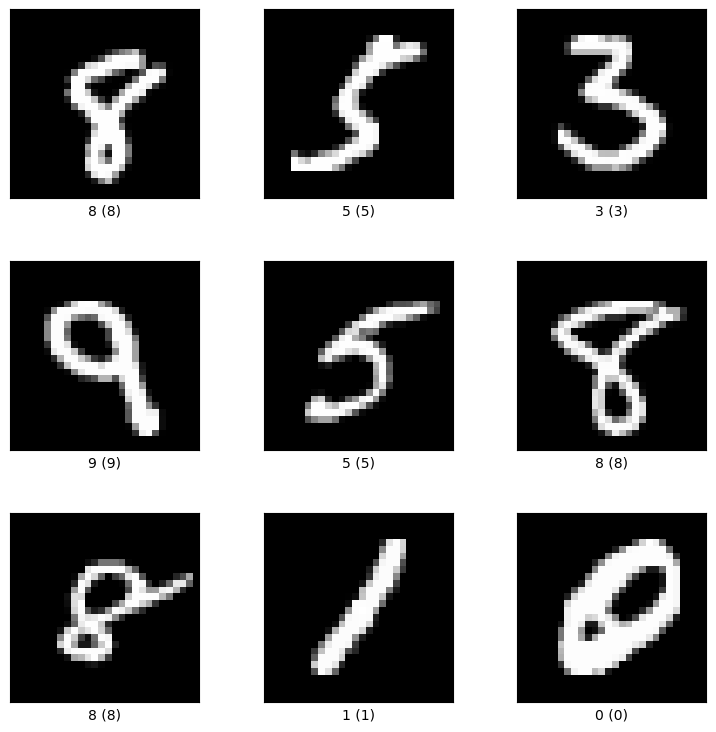

In [4]:
fig = tfdt.show_examples(data, info)

In [5]:
print(f"Number of labels: {info.features['label'].num_classes}")
print(f"Label names: {info.features['label'].names}")
print(f"Image shape: {info.features['image'].shape}")

print(f"The index 7 corresponds to digit {info.features['label'].int2str(7)}")
print(f"The digit 9 corresponds to index {info.features['label'].str2int('9')}")

Number of labels: 10
Label names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Image shape: (28, 28, 1)
The index 7 corresponds to digit 7
The digit 9 corresponds to index 9


In [6]:
# Set the variables

IMAGE_SIZE = (28,28)
BATCH_SIZE = 32
EPOCHS = 5

# Divide the dataset into training and test
training_split = data.take(int(len(data)*0.8))
testing_split = data.skip(int(len(data)*0.8))

print(f"Training images : {len(training_split)}")
print(f"Testing images : {len(testing_split)}")

Training images : 9600
Testing images : 2400


In [7]:
# Since we have the images with use in dataframe, we will be manually rescaling them and dividing them to batches.

rescale_layer = tf.keras.layers.Rescaling(1/255.)

#Building training pipeline
#1. scale the dataset
train_data = training_split.map(lambda x,y: (rescale_layer(x, training=True), y))
#2. Cache the dataset for better performance
train_data = train_data.cache()
#3. Suffle the data
train_data = train_data.shuffle(len(train_data))
#4. Divide the data into batches
train_data = train_data.batch(batch_size = 32)
#5. End with prefetch for better performance
train_data = train_data.prefetch(buffer_size = tf.data.AUTOTUNE) #AUTOTUNE helps in dynamic tunning based on available resources.


# Similarly building testing pipeline
test_data = testing_split.map(lambda x,y: (rescale_layer(x, training=True), y))
test_data = test_data.cache()
test_data = test_data.batch(batch_size = 32)
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)




## tf.keras.callbacks.ModelCheckpoint 

Callback to save the Keras model or model weights at some frequency.

From Docs:
ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint


In [ ]:
import datetime

mc_callback_directory = './callback_examples/model_checkpoint/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = mc_callback_directory,
    save_weight_only = True,
    monitor='val_accuracy',
    mode='max')

In [ ]:
# Create a model
model_1 = tf.keras.layers.Sequential([
    tf.keras.layers.flatten()
    tf.keras.layers.Conv2D()
    tf.keras.layers.Dense(10, activation)
])